In [1]:
#importing libraries
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix
import math as mt
from scipy.sparse.linalg import * #used for matrix multiplication
from scipy.sparse.linalg import svds
from scipy.sparse import csc_matrix
from scipy.stats import skew, norm, probplot
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')

In [2]:
#load first dataset
track_metadata_df = pd.read_csv('song_data.csv')
track_metadata_df.head()

,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0


In [3]:
track_metadata_df.shape

(1000000, 5)

In [4]:
#see the number of unique songs from this dataset 
print('Number of unique songs:', len(track_metadata_df.song_id.unique()))

Number of unique songs: 999056


In [5]:
#load second dataset
count_play_df = pd.read_csv('10000.txt', sep = '\t', header=None, names=['user', 'song','play_count'])
count_play_df.head()

,user,song,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


In [6]:
count_play_df.shape

(2000000, 3)

In [8]:
#we need to take care of the repeated track metadata. Since most of the case are nulls and some cases are divergent values, we will substitute all inconsistencies by their respective max value by each song Id.
unique_track_metadata_df = track_metadata_df.groupby('song_id').max().reset_index()

print('Number of rows after unique song Id treatment:', unique_track_metadata_df.shape[0])
print('Number of unique songs:', len(unique_track_metadata_df.song_id.unique()))
display(unique_track_metadata_df.head())


Number of rows after unique song Id treatment: 999056
Number of unique songs: 999056


,song_id,title,release,artist_name,year
0,SOAAABI12A8C13615F,Afro Jazziac,To Birdland And Hurry,Herbie Mann,2000
1,SOAAABT12AC46860F0,Herre Gud Ditt Dyre Namn Og Ære,Som Den Gyldne Sol Frembryter,Bergen Big Band,0
2,SOAAABX12A8C13FEB2,N.Y.C. Remix,Paris Can´t Wait,Guardner,0
3,SOAAACR12A58A79456,Irresistible,Wowie Zowie,Superchumbo,2002
4,SOAAACY12A58A79663,Untitled 1,Pine Cone Temples,Thuja,0


In [10]:
#Merge the two datasets based on the song ids 
user_song_list_count = pd.merge(count_play_df, 
                                unique_track_metadata_df, how='left', 
                                left_on='song', 
                                right_on='song_id')
user_song_list_count.rename(columns={'play_count':'listen_count'},inplace=True)
del(user_song_list_count['song_id'])

In [13]:
#Exploratory Data Analysis (EDA)
user_song_list_count.head()

,user,song,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [15]:
user_song_list_count.listen_count.describe().reset_index().T

,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
listen_count,2e+06,3.04548,6.57972,1,1,1,3,2213


WOW Super interesting ! it looks like we have some users obsessed with a single song! A user having heard 2,213 times a single song is something very extreme considering that we have only 3 times in the third quartile. Let's check how many users listen to a single song more than 3 times and more than 200 times.

In [18]:
print('{:d} users, {:.2%} of total play counts, listening to a single song more than 200 times'.format(
    count_play_df.user[count_play_df.play_count>200].unique().shape[0],
    count_play_df.play_count[count_play_df.play_count>200].count()/count_play_df.shape[0]))
display(count_play_df.play_count[count_play_df.play_count>200].describe().reset_index().T)

118 users, 0.01% of total play counts, listening to a single song more than 200 times


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
play_count,140,327.107,209.115,201,225,267,353.75,2213


So, as we can see only 118 users listen to a single song more than 200 times, but, would this be possible?

Let's consider that a song has 3:30 minutes in average and create it for the two most obsessed users and check out what their songs are:

In [24]:
lunatic = count_play_df.play_count[count_play_df.play_count>count_play_df.play_count.max()-10].values[0]
print('- How many days the most obsessed user can be listening to a unique song: {:.1f}'.format((lunatic*3.5)/60/24))
display(track_metadata_df[track_metadata_df.song_id.isin(
                  count_play_df[count_play_df.play_count>count_play_df.play_count.max()-10].song.values)])

- How many days the most obsessed user can be listening to a unique song: 5.4


,song_id,title,release,artist_name,year
567847,SOFCGSE12AF72A674F,Starshine,Gorillaz,Gorillaz,2000


In [25]:
obsessed = count_play_df.play_count[count_play_df.play_count>count_play_df.play_count.max()-1500].values[1]
print('- How many days the second obsessed user can be listening to a unique song: {:.1f}'.format((obsessed*3)/60/24))
display(track_metadata_df[track_metadata_df.song_id.isin(count_play_df[count_play_df.play_count==920].song.values)])

- How many days the second obsessed user can be listening to a unique song: 1.9


,song_id,title,release,artist_name,year
927746,SOUAGPQ12A8AE47B3A,Crack Under Pressure,Stress related / Live and learn,Righteous Pigs,1998


So we have to be careful when creating a recommendation system that can be affected by the outliers. Let's take a look at the top 20 in the different features we have


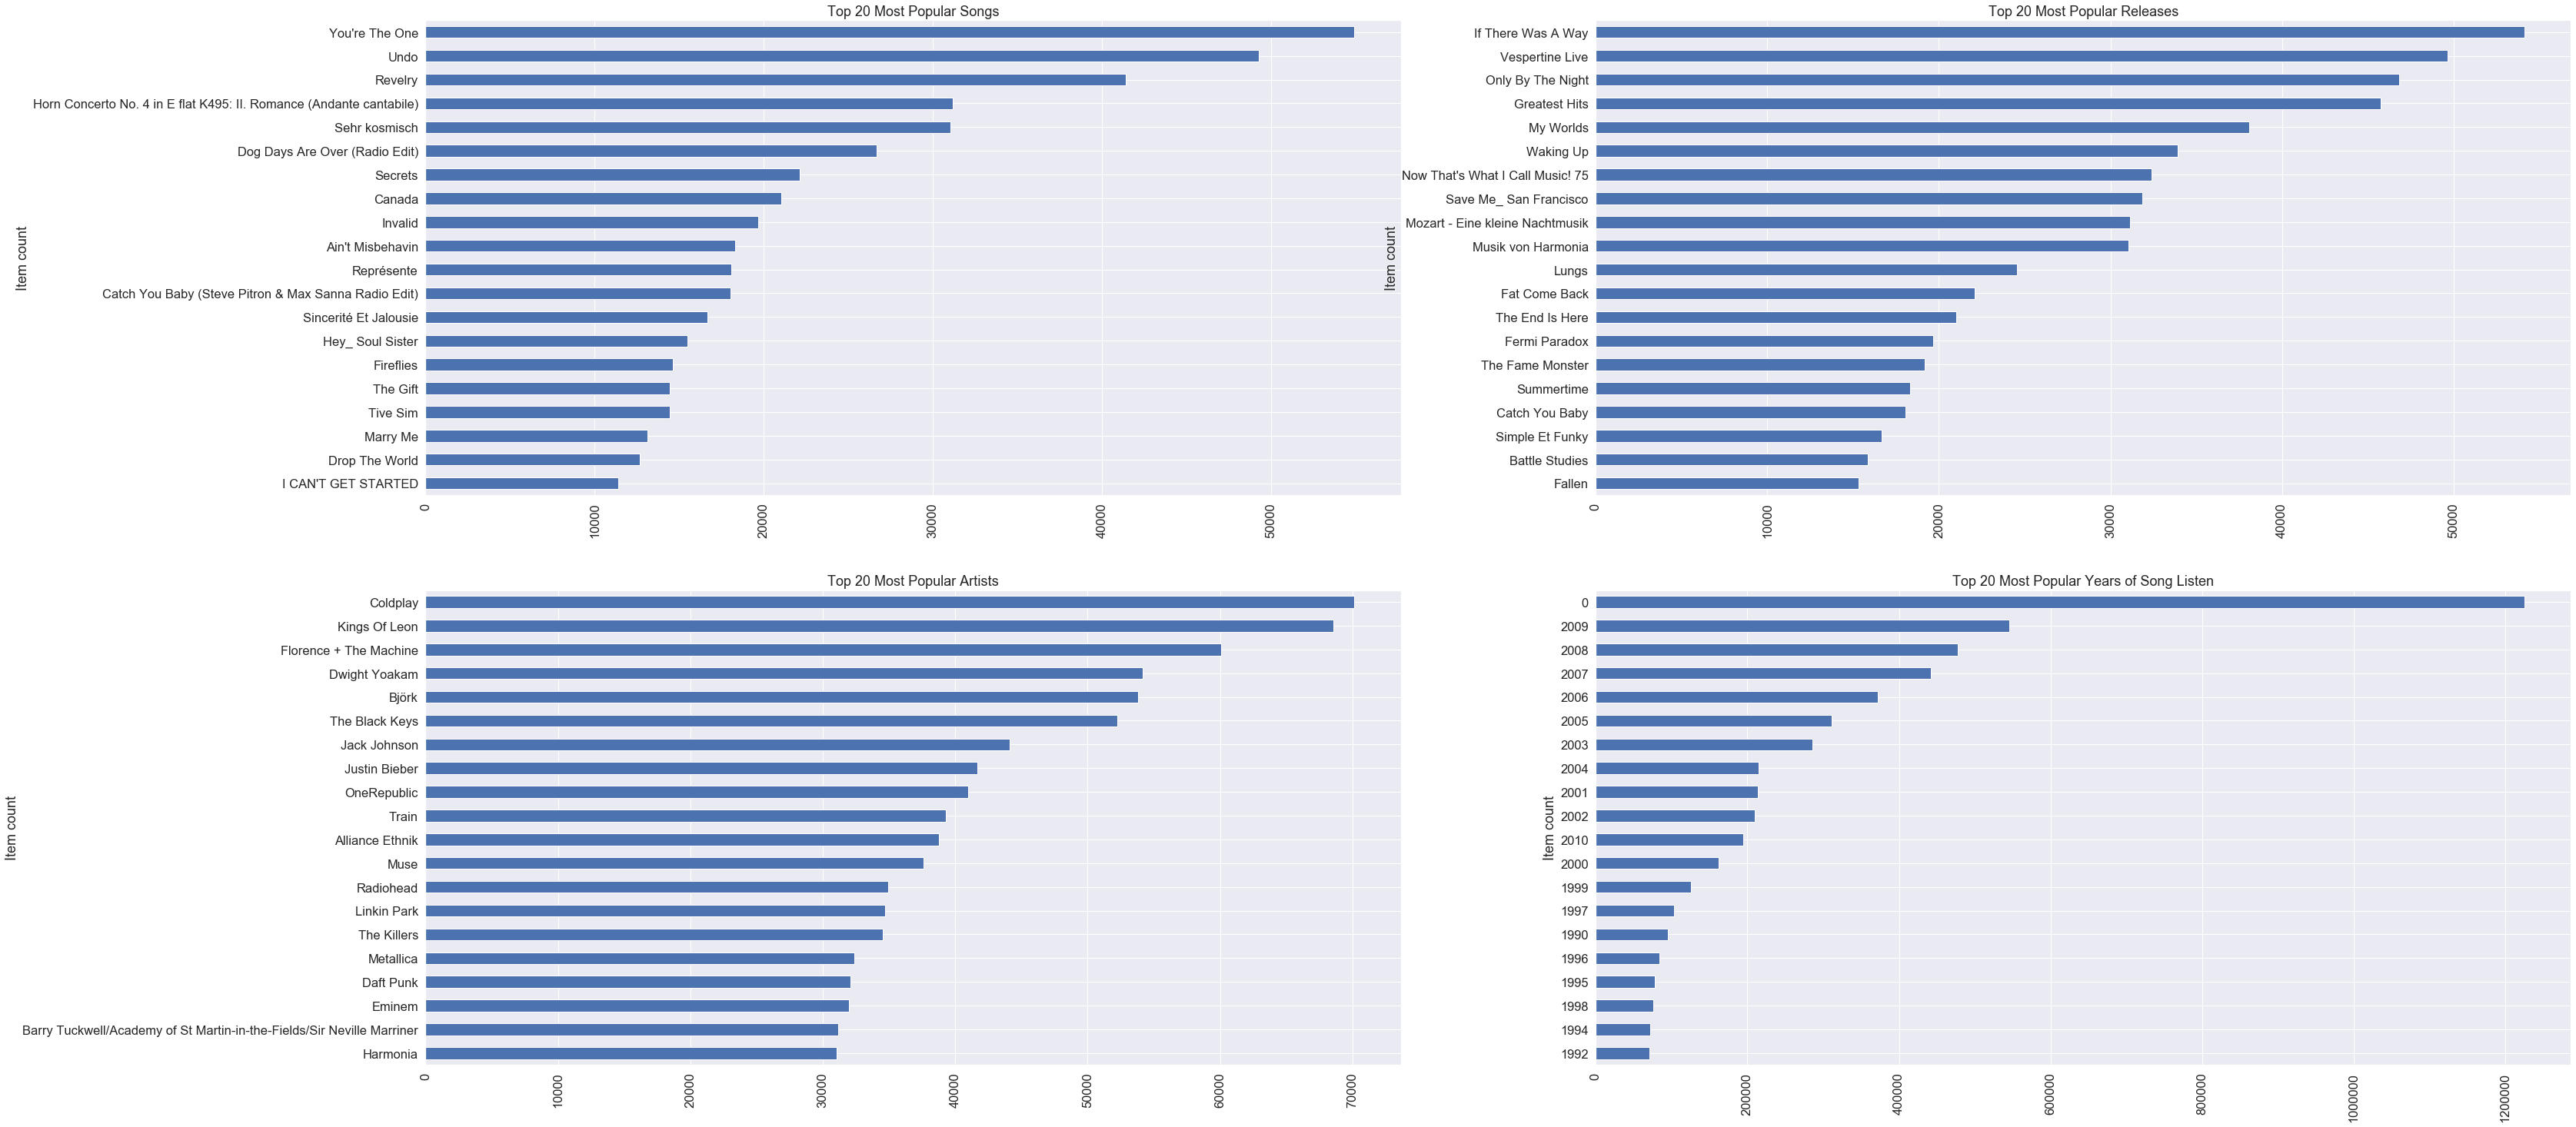

In [26]:
fig = plt.figure(figsize=(50, 25))
a1 = fig.add_subplot(221)
popular_songs = user_song_list_count[['title','listen_count']].groupby('title').sum().\
                sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
f1 = popular_songs.plot(kind='barh', title='Top 20 Most Popular Songs', legend=False, ax=a1)
plt.xticks(rotation='vertical')
plt.ylabel('Item count')

a2 = fig.add_subplot(222)
popular_release = user_song_list_count[['release','listen_count']].groupby('release').sum().\
                sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
f2 = popular_release.plot(kind='barh', title='Top 20 Most Popular Releases', legend=False, ax=a2)
plt.xticks(rotation='vertical')
plt.ylabel('Item count')

a3 = fig.add_subplot(223)
popular_artist = user_song_list_count[['artist_name','listen_count']].groupby('artist_name').sum().\
                sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
f1 = popular_artist.plot(kind='barh', title='Top 20 Most Popular Artists', legend=False, ax=a3)
plt.xticks(rotation='vertical')
plt.ylabel('Item count')

a4 = fig.add_subplot(224)
popular_year = user_song_list_count[['year','listen_count']].groupby('year').sum().\
                sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
f1 = popular_year.plot(kind='barh', title='Top 20 Most Popular Years of Song Listen', legend=False, ax=a4)
plt.xticks(rotation='vertical')
plt.ylabel('Item count')

plt.show()

So the two most obsessed fans did not influence any of the top 20.Let's take a look at the distribution of how many different songs each user listens to, first we create a summary dataset and next a function to help us with better visualization.

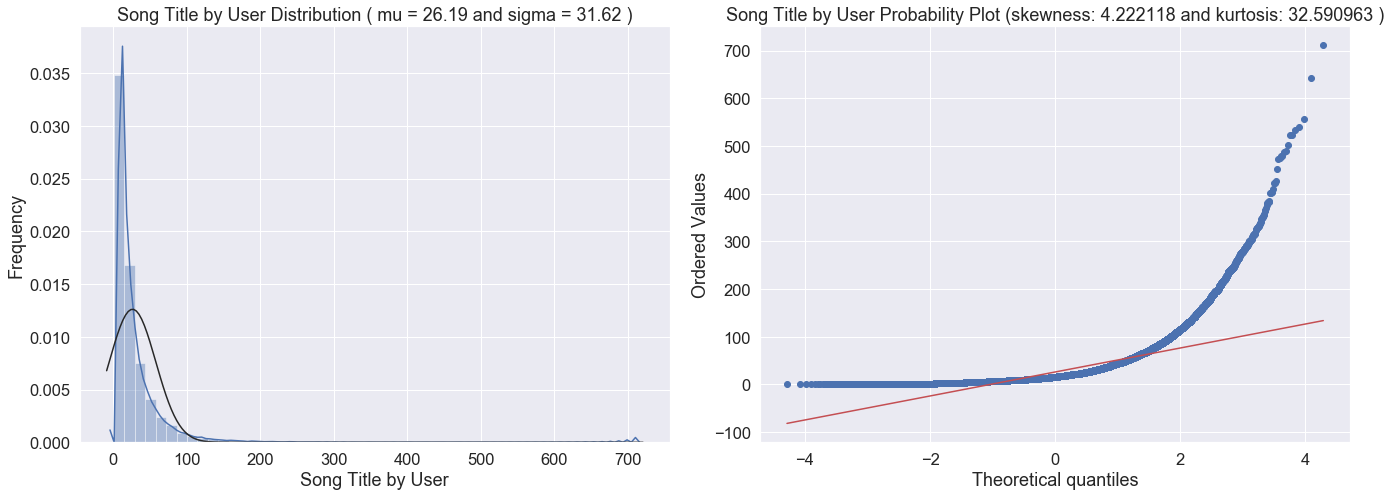

,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
title,76353,26.1941,31.6251,1,9,16,31,711


In [27]:
user_song_count_distribution = user_song_list_count[['user','title']].groupby('user').count().\
                                reset_index().sort_values(by='title',ascending = False)

def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')


#QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()

QQ_plot(user_song_count_distribution.title, 'Song Title by User')
user_song_count_distribution.title.describe().reset_index().T

Explanations: 
From the first graph above we can see that song title by user distribution is skewed, has a peak on the left and a long tail to the right. It deviates from normal distribution and is positively biased.. As we expect, less than a hundred listen to a good number of different songs, but enough to raise the average to above 26.

From the Probability Plot, we could see that song title by user also does not align with the diagonal red line which represent normal distribution. The form of its distribution confirm that is a skewed right.

With skewness positive of 4.2, we confirm the lack of symmetry and indicate that song title by user are skewed right, as we can see too at the song title by user distribution plot, skewed right means that the right tail is long relative to the left tail, as we expect in counts. The skewness for a normal distribution is zero, and any symmetric data should have a skewness near zero. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.

Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers, and positive kurtosis indicates a heavy-tailed distribution and negative kurtosis indicates a light tailed distribution. So, with 32.6 of positive kurtosis song title by user are heavy-tailed and definitely has outliers.

let's take a look at the distribution of the number of times users heard the most popular song.

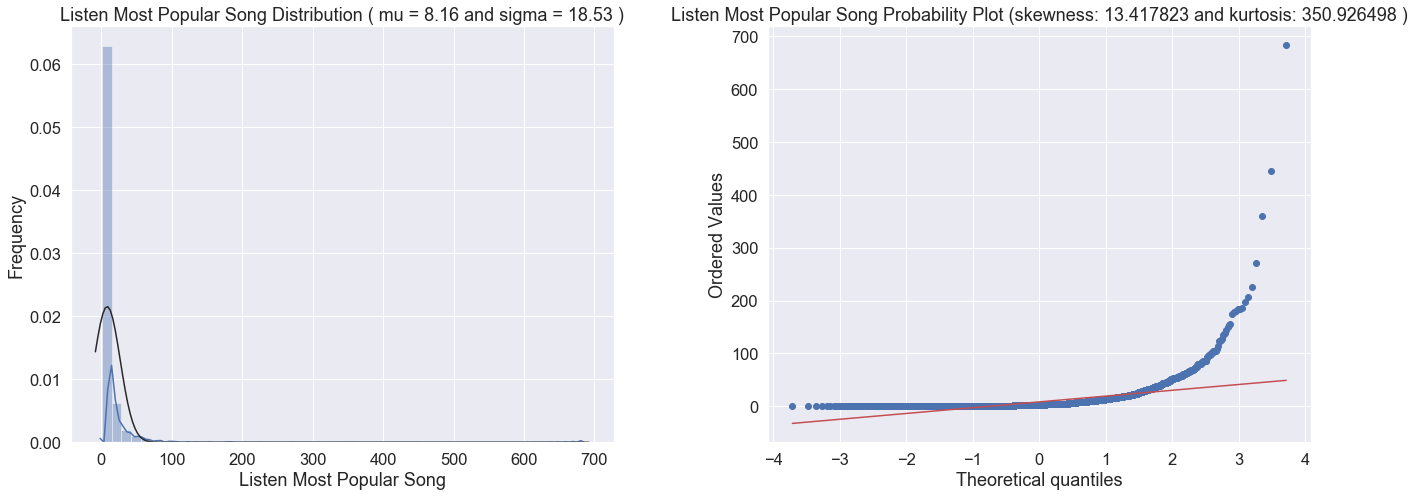

In [30]:
QQ_plot(user_song_list_count[user_song_list_count.title=="You're The One"].listen_count, 'Listen Most Popular Song')

Finally, Recommendation Engine ! 
The basis of the recommendation engine is always the recorded interaction between the users and products.



There are 3 types of recommendation engines: 1: User-based recommendation engine. 2: Content-based recommendation engine. 3: Hybird-recommendation engine. 

This project focuses on the hybird-recommendation engines Sometimes termed as collaborative filtering recommendation engines, these are one of the most effective classes of recommendation engines, as they take the best features of both classes, users and content of recommendation engines.

In particular, this project focues on Matrix Factorization based recommendation engine. 

Matrix factorization is a class of collaborative filtering algorithms used in recommender systems.

Matrix factorization is a way to generate latent features when multiplying two different kinds of entities. Collaborative filtering is the application of matrix factorization to identify the relationship between items’ and users’ entities. With the input of users’ ratings on the shop items, we would like to predict how the users would rate the items so the users can get the recommendation based on the prediction.


Matrix Factorization and Singular Value Decomposition (SVD)
There are multiple algorithms available for determining factorization of any matrix. We use one of the simplest algorithms, which is the singular value decomposition or SVD. You can follow these steps to determine the factorization of a matrix using the output of SVD function.

Factorize the matrix to obtain U, S, and V matrices.
Reduce the matrix S to first k components. (The function we are using will only provide k dimensions, so we can skip this step.)
Compute the square root of reduced matrix Sk to obtain the matrix Sk1/2.
Compute the two resultant matrix U*Sk1/2 and Sk1/2*V as these will serve as our two factorized matrices

We can then generate the prediction of user i for product j by taking the dot product of the ith row of the first matrix with the jth column of the second matrix.

Let's create tree functions to help us on it:

compute_svd: It use the svds function provided by the scipy library to break down our utility matrix into three different matrices, and prosed with the others tree steps above.
compute_estimated_matrix: use the decomposed matrices by SVD and provide the predictions.

In [51]:
def compute_svd(urm, K):
    U, s, Vt = svds(urm, K)

    dim = (len(s), len(s))
    S = np.zeros(dim, dtype=np.float32)
    for i in range(0, len(s)):
        S[i,i] = mt.sqrt(s[i])

    U = csc_matrix(U, dtype=np.float32)
    S = csc_matrix(S, dtype=np.float32)
    Vt = csc_matrix(Vt, dtype=np.float32)
    
    return U, S, Vt

def compute_estimated_matrix(urm, U, S, Vt, uTest, K, test):
    rightTerm = S*Vt 
    max_recommendation = 250
    estimatedRatings = np.zeros(shape=(MAX_UID, MAX_PID), dtype=np.float16)
    recomendRatings = np.zeros(shape=(MAX_UID,max_recommendation ), dtype=np.float16)
    for userTest in uTest:
        prod = U[userTest, :]*rightTerm
        estimatedRatings[userTest, :] = prod.todense()
        recomendRatings[userTest, :] = (-estimatedRatings[userTest, :]).argsort()[:max_recommendation]
    return recomendRatings

def show_recomendations(uTest, num_recomendations = 10):
    for user in uTest:
        print('-'*70)
        print("Recommendation for user id {}".format(user))
        rank_value = 1
        i = 0
        while (rank_value <  num_recomendations + 1):
            so = uTest_recommended_items[user,i:i+1][0]
            if (small_set.user[(small_set.so_index_value == so) & (small_set.us_index_value == user)].count()==0):
                song_details = small_set[(small_set.so_index_value == so)].\
                    drop_duplicates('so_index_value')[['title','artist_name']]
                print("The number {} recommended song is {} BY {}".format(rank_value, 
                                                                      list(song_details['title'])[0],
                                                                      list(song_details['artist_name'])[0]))
                rank_value+=1
            i += 1


The first thing that we notice is that we have no concept of "rating" in our data. All we have are the play counts of various songs. This is a well known problem in the case of recommendation engines and is called the "implicit feedback" problem. There are many ways to solve this problem but we will look at a very simple and intuitive solution. We will replace the play count with a fractional play count. The logic being that this will measure the strength of "likeness" for a song in the range of [0,1].

In [52]:
user_song_list_listen = user_song_list_count[['user', 'listen_count']].groupby('user').sum().reset_index()
user_song_list_listen.rename(columns={'listen_count': 'total_listen_count'},inplace = True)
user_song_list_count_merged = pd.merge(user_song_list_count, user_song_list_listen)
user_song_list_count_merged['fractional_play_count'] = \
    user_song_list_count_merged['listen_count']/user_song_list_count_merged['total_listen_count']
display(user_song_list_count_merged[user_song_list_count_merged.user == 'd6589314c0a9bcbca4fee0c93b14bc402363afea']\
               [['user', 'song', 'listen_count', 'fractional_play_count']].head())


,user,song,listen_count,fractional_play_count
299,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12,0.038961
300,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1,0.003247
301,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1,0.003247
302,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1,0.003247
303,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,0.022727


The next transformation of data that is required is to convert our dataframe into a numpy matrix in the format of utility matrix. We will convert our dataframe into a sparse matrix, as we will have a lot of missing values and sparse matrices are suitable for representation of such a matrix. Since we won't be able to transform our song IDs and user IDs into a numpy matrix, we will convert these indices into numerical indices. Then we will use these transformed indices to create our sparse numpy matrix.

In [53]:
user_codes = user_song_list_count_merged.user.drop_duplicates().reset_index()
user_codes.rename(columns={'index':'user_index'}, inplace=True)
user_codes['us_index_value'] = list(user_codes.index)

song_codes = user_song_list_count_merged.song.drop_duplicates().reset_index()
song_codes.rename(columns={'index':'song_index'}, inplace=True)
song_codes['so_index_value'] = list(song_codes.index)

small_set = pd.merge(user_song_list_count_merged,song_codes,how='left')
small_set = pd.merge(small_set,user_codes,how='left')
mat_candidate = small_set[['us_index_value','so_index_value','fractional_play_count']]

data_array = mat_candidate.fractional_play_count.values
row_array = mat_candidate.us_index_value.values
col_array = mat_candidate.so_index_value.values

data_sparse = coo_matrix((data_array, (row_array, col_array)),dtype=float)

display(data_sparse)

print('User used to performed the item similarity based recommendations earlie:.')
display(user_codes[user_codes.user =='b80344d063b5ccb3212f76538f3d9e43d87dca9e'])



<76353x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 2000000 stored elements in COOrdinate format>

User used to performed the item similarity based recommendations earlie:.


,user_index,user,us_index_value
0,0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,0


Once we have converted our matrix into a sparse matrix, we specify 50 as the number of latent factors we want to factorize our data and call ours functions first to compute the SVD, followed by the compute estimated matrix for the users ids sets by uTest variable:

In [ ]:
#print out the songs that user id 5 like 


In [56]:
K=50
urm = data_sparse
MAX_PID = urm.shape[1]
MAX_UID = urm.shape[0]

U, S, Vt = compute_svd(urm, K)
uTest = [5,10,11,12,30,535,857]

uTest_recommended_items = compute_estimated_matrix(urm, U, S, Vt, uTest, K, True)

show_recomendations(uTest)

----------------------------------------------------------------------
Recommendation for user id 5
The number 1 recommended song is Eenie Meenie BY Sean Kingston and Justin Bieber
The number 2 recommended song is Sample Track 2 BY Simon Harris
The number 3 recommended song is U Smile BY Justin Bieber
The number 4 recommended song is Love Me BY Justin Bieber
The number 5 recommended song is One Time BY Justin Bieber
The number 6 recommended song is That Should Be Me BY Justin Bieber
The number 7 recommended song is Teach Me How To Dougie BY California Swag District
The number 8 recommended song is The Gift BY Angels and Airwaves
The number 9 recommended song is Kennedy Rag BY Suzy Thompson
The number 10 recommended song is One Less Lonely Girl BY Justin Bieber
----------------------------------------------------------------------
Recommendation for user id 10
The number 1 recommended song is Just Dance BY Lady GaGa / Colby O'Donis
The number 2 recommended song is Unite (2009 Digital Re